## Esercizio Time Series

<img src='https://www.investopedia.com/thmb/6EKKyc5osPzwjc5pNtGz64fQWmE=/750x0/filters:no_upscale():max_bytes(150000):strip_icc():format(webp)/TermDefinitions_TimeSeries__V1_CT-e4cb9fe23caf415491b1e850a1be300b.png' width=800>


In [ ]:
# !wget https://frenzy86.s3.eu-west-2.amazonaws.com/python/data/ads.csv

In [23]:
import numpy as np
import pandas as pd
# Analisi della distribuzione
import matplotlib.pyplot as plt
import seaborn as sns
from statsmodels.tsa.seasonal import seasonal_decompose
from statsmodels.graphics.tsaplots import plot_acf, plot_pacf
from sklearn.metrics import mean_squared_error, mean_absolute_error, r2_score
from sklearn.model_selection import TimeSeriesSplit
from sklearn.linear_model import LinearRegression
from sklearn.ensemble import RandomForestRegressor
from xgboost import XGBRegressor
from statsmodels.tsa.statespace.sarimax import SARIMAX
from statsmodels.tsa.arima.model import ARIMA
from prophet import Prophet



import warnings
warnings.filterwarnings('ignore')

path = 'https://frenzy86.s3.eu-west-2.amazonaws.com/python/data/ads.csv'

In [3]:
df = pd.read_csv(path)

In [4]:
df

,Time,Ads
0,2017-09-13T00:00:00,80115
1,2017-09-13T01:00:00,79885
2,2017-09-13T02:00:00,89325
3,2017-09-13T03:00:00,101930
4,2017-09-13T04:00:00,121630
...,...,...
211,2017-09-21T19:00:00,155890
212,2017-09-21T20:00:00,123395
213,2017-09-21T21:00:00,103080
214,2017-09-21T22:00:00,95155


In [7]:
# Fare EDA e decomposition

# Convertire la colonna 'Time' in formato datetime
df['Time'] = pd.to_datetime(df['Time'])

# Impostare 'Time' come indice
df_ts = df.set_index('Time')

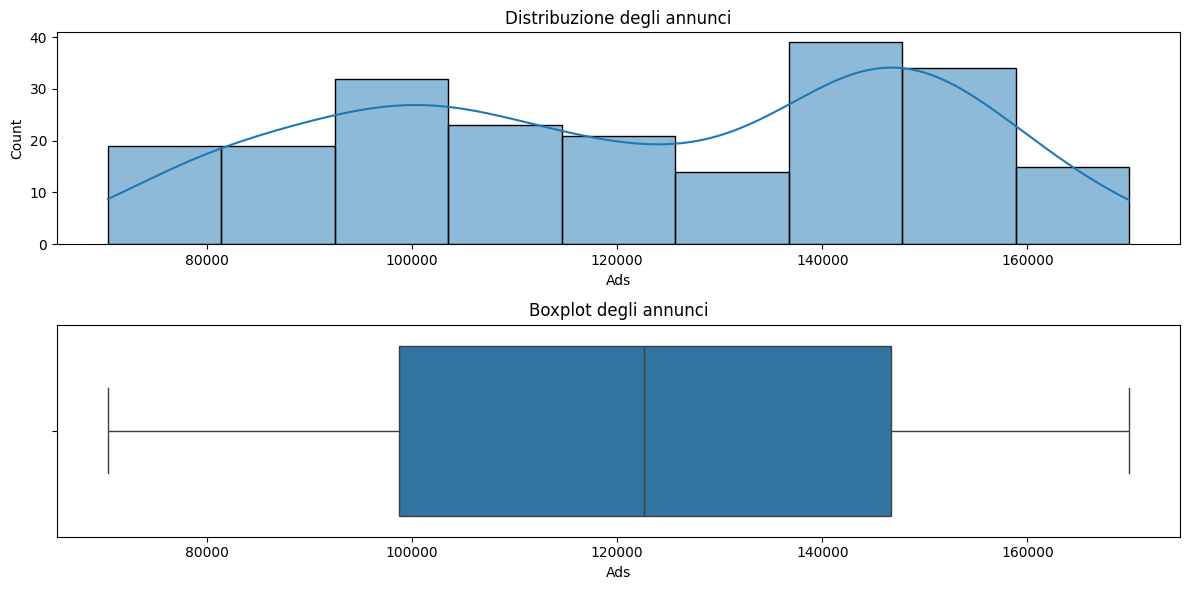

In [8]:
plt.figure(figsize=(12, 6))
plt.subplot(211)
sns.histplot(df['Ads'], kde=True)
plt.title('Distribuzione degli annunci')
plt.subplot(212)
sns.boxplot(x=df['Ads'])
plt.title('Boxplot degli annunci')
plt.tight_layout()
plt.show()

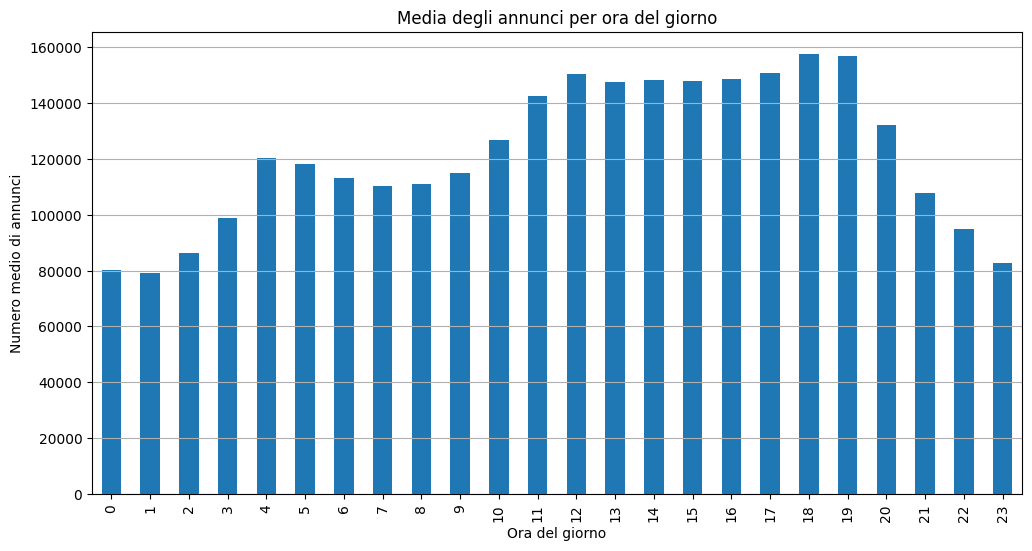

In [9]:
# Analisi per ora del giorno
df['Hour'] = df['Time'].dt.hour
hourly_avg = df.groupby('Hour')['Ads'].mean()

plt.figure(figsize=(12, 6))
hourly_avg.plot(kind='bar')
plt.title('Media degli annunci per ora del giorno')
plt.xlabel('Ora del giorno')
plt.ylabel('Numero medio di annunci')
plt.grid(True, axis='y')
plt.show()

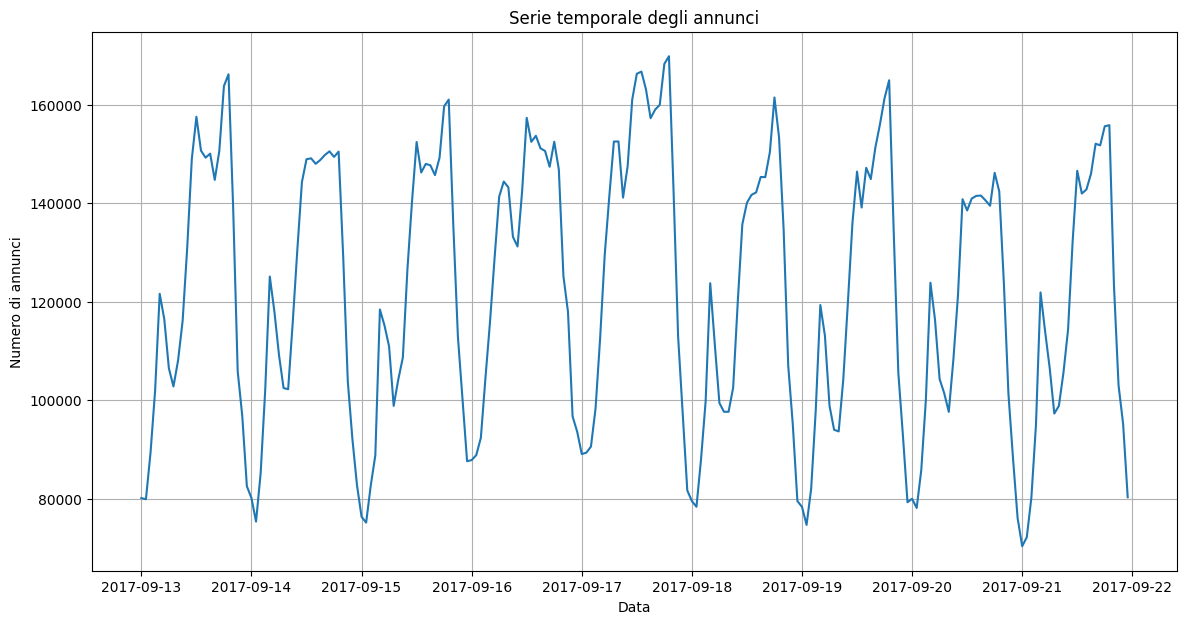

In [10]:
# Analisi della serie temporale
plt.figure(figsize=(14, 7))
plt.plot(df_ts.index, df_ts['Ads'])
plt.title('Serie temporale degli annunci')
plt.xlabel('Data')
plt.ylabel('Numero di annunci')
plt.grid(True)
plt.show()

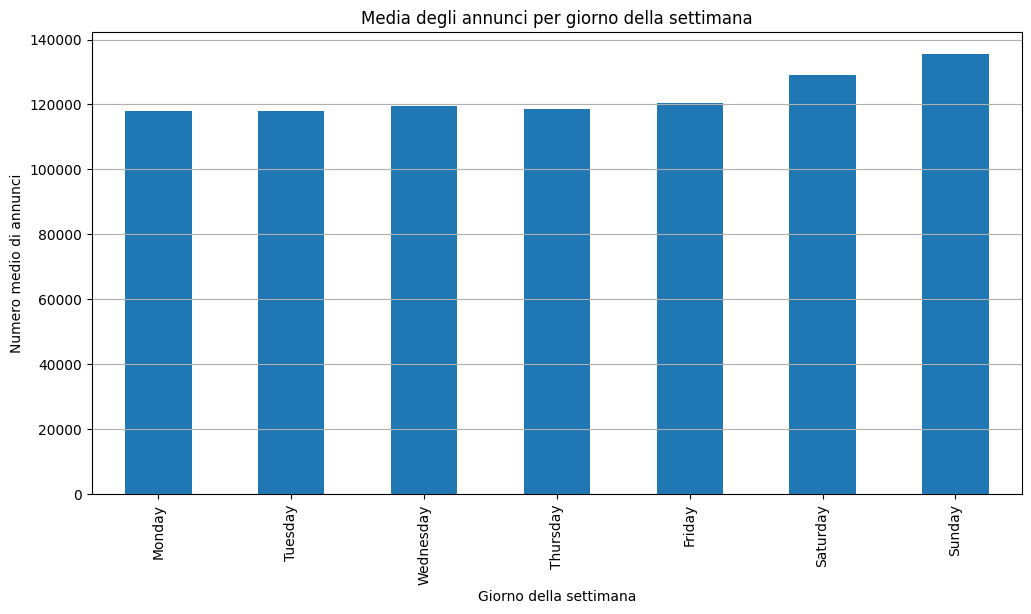

In [11]:
# Analisi per giorno della settimana
df['DayOfWeek'] = df['Time'].dt.day_name()
day_order = ['Monday', 'Tuesday', 'Wednesday', 'Thursday', 'Friday', 'Saturday', 'Sunday']
daily_avg = df.groupby('DayOfWeek')['Ads'].mean().reindex(day_order)

plt.figure(figsize=(12, 6))
daily_avg.plot(kind='bar')
plt.title('Media degli annunci per giorno della settimana')
plt.xlabel('Giorno della settimana')
plt.ylabel('Numero medio di annunci')
plt.grid(True, axis='y')
plt.show()

In [ ]:
# Decomposizione della serie temporale
# Resample a frequenza giornaliera
daily_data = df_ts.resample('D').mean()

# Decomposizione additiva
decomposition_add = seasonal_decompose(daily_data, model='additive', period=4)

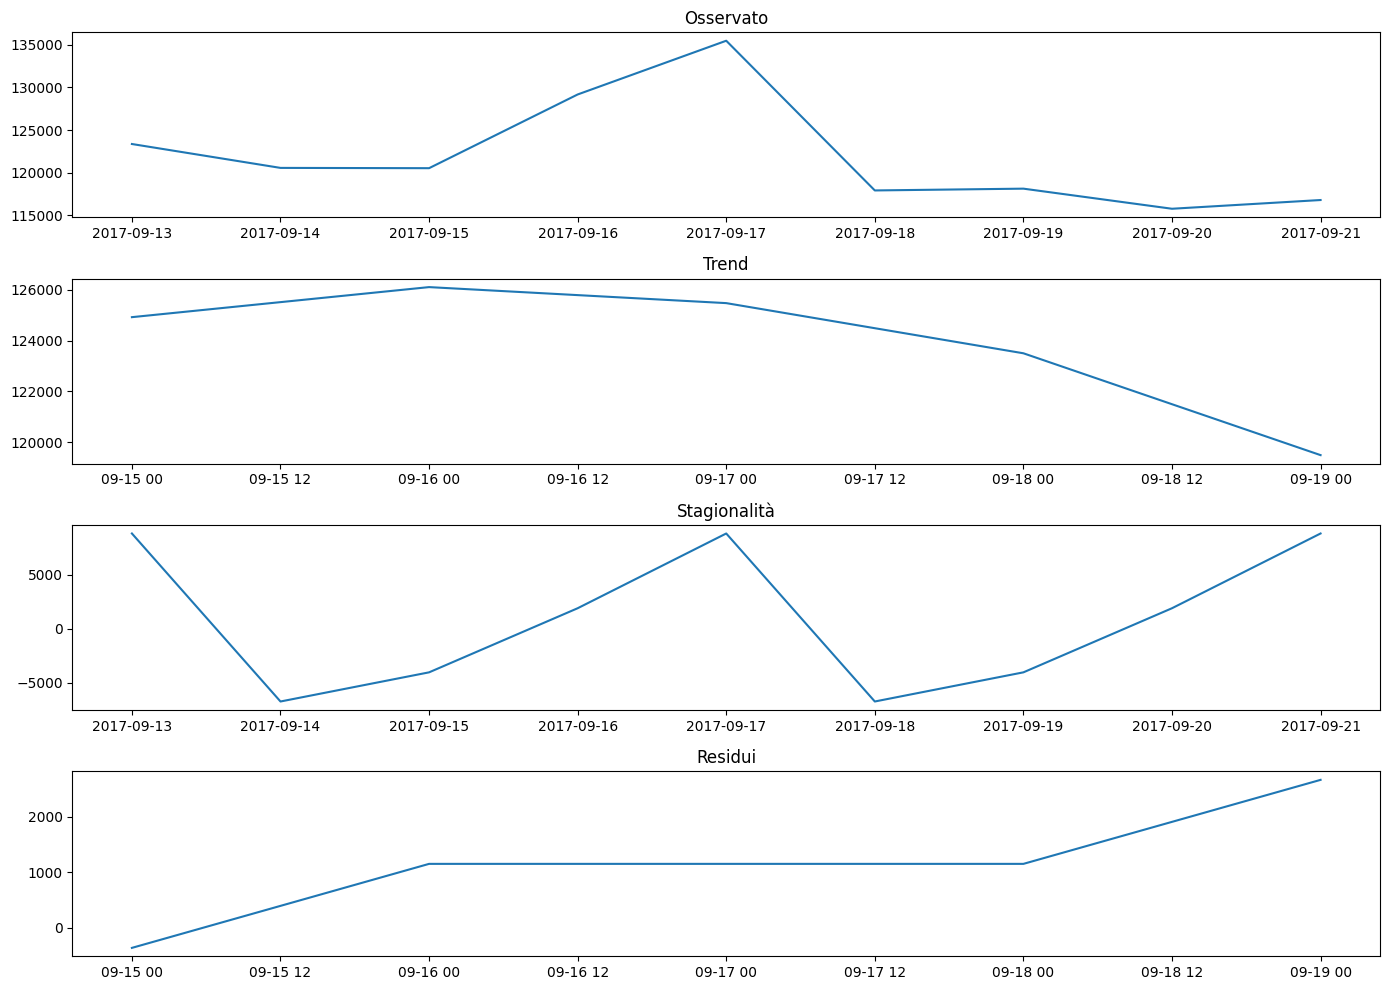

In [17]:
plt.figure(figsize=(14, 10))
plt.subplot(411)
plt.plot(decomposition_add.observed)
plt.title('Osservato')
plt.subplot(412)
plt.plot(decomposition_add.trend)
plt.title('Trend')
plt.subplot(413)
plt.plot(decomposition_add.seasonal)
plt.title('Stagionalità')
plt.subplot(414)
plt.plot(decomposition_add.resid)
plt.title('Residui')
plt.tight_layout()
plt.show()

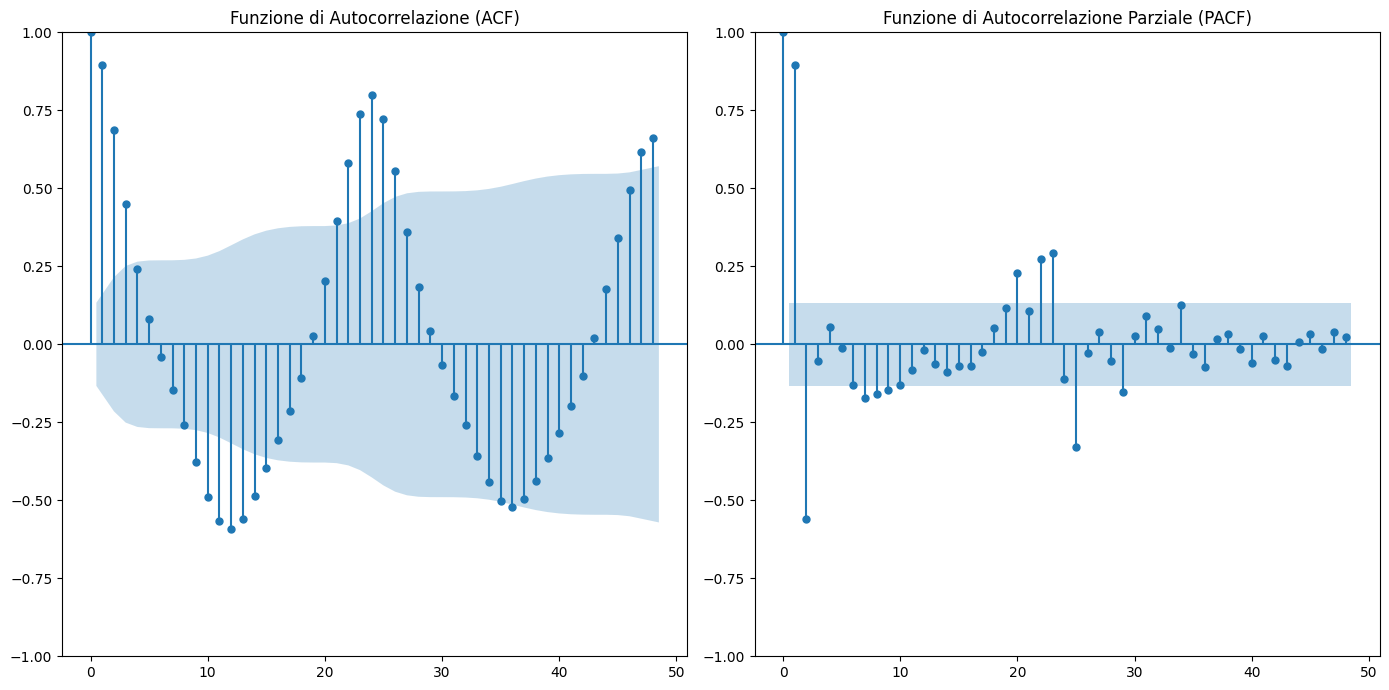

In [20]:
# Autocorrelazione e autocorrelazione parziale
plt.figure(figsize=(14, 7))
plt.subplot(121)
plot_acf(df_ts['Ads'], lags=48, ax=plt.gca())
plt.title('Funzione di Autocorrelazione (ACF)')
plt.subplot(122)
plot_pacf(df_ts['Ads'], lags=48, ax=plt.gca())
plt.title('Funzione di Autocorrelazione Parziale (PACF)')
plt.tight_layout()
plt.show()


In [21]:
# Visualizzare le informazioni di base
print("Informazioni sul dataset:")
print(f"Dimensioni: {df.shape}")
print(f"Periodo: da {df['Time'].min()} a {df['Time'].max()}")
print(f"Numero di ore: {df['Time'].nunique()}")
print("\nStatistiche descrittive:")
print(df['Ads'].describe())

# Controllare valori mancanti
print("\nValori mancanti:")
print(df.isna().sum())

# Resample dei dati per diverse granularità temporali
print("\nMedia giornaliera:")
daily_mean = df_ts.resample('D').mean()
print(daily_mean.head())

print("\nMedia settimanale:")
weekly_mean = df_ts.resample('W').mean()
print(weekly_mean.head())

Informazioni sul dataset:
Dimensioni: (216, 4)
Periodo: da 2017-09-13 00:00:00 a 2017-09-21 23:00:00
Numero di ore: 216

Statistiche descrittive:
count       216.000000
mean     121974.050926
std       27259.406772
min       70335.000000
25%       98717.500000
50%      122652.500000
75%      146691.250000
max      169900.000000
Name: Ads, dtype: float64

Valori mancanti:
Time         0
Ads          0
Hour         0
DayOfWeek    0
dtype: int64

Media giornaliera:
                      Ads
Time                     
2017-09-13  123368.333333
2017-09-14  120569.583333
2017-09-15  120535.416667
2017-09-16  129172.291667
2017-09-17  135468.750000

Media settimanale:
                      Ads
Time                     
2017-09-17  125822.875000
2017-09-24  117163.020833


In [24]:
# Definizione di una funzione per la valutazione dei modelli
def valuta_modello(modello, nome_modello, X_train, y_train, X_test, y_test):
    # Addestramento del modello
    modello.fit(X_train, y_train)
    # Previsioni
    previsioni = modello.predict(X_test)
    # Calcolo delle metriche
    mse = mean_squared_error(y_test, previsioni)
    rmse = np.sqrt(mse)
    mae = mean_absolute_error(y_test, previsioni)
    r2 = r2_score(y_test, previsioni)
    
    print(f"Risultati per {nome_modello}:")
    print(f"MSE: {mse:.2f}")
    print(f"RMSE: {rmse:.2f}")
    print(f"MAE: {mae:.2f}")
    print(f"R²: {r2:.4f}")
    print("-" * 50)
    
    return {
        'modello': modello,
        'nome': nome_modello,
        'mse': mse,
        'rmse': rmse,
        'mae': mae,
        'r2': r2,
        'previsioni': previsioni
    }

In [25]:
#feature engineering

df_features = df_ts.copy()
df_features['hour'] = df_features.index.hour
df_features['dayofweek'] = df_features.index.dayofweek
df_features['quarter'] = df_features.index.quarter
df_features['month'] = df_features.index.month
df_features['dayofyear'] = df_features.index.dayofyear
df_features['weekofyear'] = df_features.index.isocalendar().week

# Aggiungiamo lag features (valori precedenti)
for i in range(1, 25):  # Lag di 1-24 ore
    df_features[f'lag_{i}'] = df_features['Ads'].shift(i)

# Aggiungiamo medie mobili
df_features['rolling_mean_6h'] = df_features['Ads'].rolling(window=6).mean()
df_features['rolling_mean_12h'] = df_features['Ads'].rolling(window=12).mean()
df_features['rolling_mean_24h'] = df_features['Ads'].rolling(window=24).mean()

# Rimuoviamo le righe con valori NaN (causati dai lag e dalle medie mobili)
df_features = df_features.dropna()

In [29]:
# Definiamo le feature e il target
X = df_features.drop('Ads', axis=1)
y = df_features['Ads']

tscv = TimeSeriesSplit(n_splits=5)

In [32]:
# Lista per memorizzare i risultati
risultati_modelli = []

# Inizializziamo i modelli da testare
modelli = {
    'Random Forest': RandomForestRegressor(n_estimators=100, random_state=42),
    'XGBoost': XGBRegressor(n_estimators=100, learning_rate=0.1, random_state=42),
    'ARIMA': ARIMA(y, order=(2, 1, 2)),
    'SARIMA': SARIMAX(y, order=(1, 1, 1), seasonal_order=(1, 1, 1, 24)),
    'Prophet': Prophet(),
}


# Eseguiamo la cross-validation
for nome_modello, modello in modelli.items():
    if nome_modello not in ['ARIMA', 'SARIMA', 'Prophet']:  # Modelli ML standard
        cv_scores = []
        
        for train_idx, test_idx in tscv.split(X):
            X_train, X_test = X.iloc[train_idx], X.iloc[test_idx]
            y_train, y_test = y.iloc[train_idx], y.iloc[test_idx]
            
            risultato = valuta_modello(modello, nome_modello, X_train, y_train, X_test, y_test)
            cv_scores.append(risultato['rmse'])
        
        print(f"CV RMSE medio per {nome_modello}: {np.mean(cv_scores):.2f}")
        risultati_modelli.append({
            'nome': nome_modello,
            'rmse_medio': np.mean(cv_scores),
            'modello': modello
        })
    elif nome_modello in ['ARIMA', 'SARIMA']:  # Modelli ARIMA/SARIMA
        
        cv_scores = []
        
        for train_idx, test_idx in tscv.split(y):
            y_train, y_test = y.iloc[train_idx], y.iloc[test_idx]
            
            if nome_modello == 'ARIMA':
                model = ARIMA(y_train, order=(2, 1, 2))
                model_fit = model.fit()
                previsioni = model_fit.forecast(steps=len(y_test))
            else:  # SARIMA
                model = SARIMAX(y_train, order=(1, 1, 1), seasonal_order=(1, 1, 1, 24))
                model_fit = model.fit(disp=False)
                previsioni = model_fit.forecast(steps=len(y_test))
            
            rmse = np.sqrt(mean_squared_error(y_test, previsioni))
            cv_scores.append(rmse)
        
        print(f"CV RMSE medio per {nome_modello}: {np.mean(cv_scores):.2f}")
        risultati_modelli.append({
            'nome': nome_modello,
            'rmse_medio': np.mean(cv_scores),
            'modello': modello
        })
    else:  # Prophet
        cv_scores = []
        
        for train_idx, test_idx in tscv.split(y):
            y_train, y_test = y.iloc[train_idx], y.iloc[test_idx]
            
            # Prepariamo i dati nel formato richiesto da Prophet (ds, y)
            df_train = pd.DataFrame({
                'ds': y_train.index,
                'y': y_train.values
            })
            
            # Addestriamo il modello Prophet
            model = Prophet()
            model.fit(df_train)
            
            # Creiamo il dataframe per le previsioni
            future = pd.DataFrame({'ds': y_test.index})
            forecast = model.predict(future)
            
            # Calcoliamo l'RMSE
            rmse = np.sqrt(mean_squared_error(y_test.values, forecast['yhat'].values))
            cv_scores.append(rmse)
        
        print(f"CV RMSE medio per {nome_modello}: {np.mean(cv_scores):.2f}")
        risultati_modelli.append({
            'nome': nome_modello,
            'rmse_medio': np.mean(cv_scores),
            'modello': modello
        })


Risultati per Random Forest:
MSE: 213433865.51
RMSE: 14609.38
MAE: 9839.32
R²: 0.5929
--------------------------------------------------
Risultati per Random Forest:
MSE: 111357035.92
RMSE: 10552.58
MAE: 8705.08
R²: 0.8607
--------------------------------------------------
Risultati per Random Forest:
MSE: 172100817.99
RMSE: 13118.72
MAE: 9190.55
R²: 0.7359
--------------------------------------------------
Risultati per Random Forest:
MSE: 22475812.62
RMSE: 4740.87
MAE: 3901.58
R²: 0.9652
--------------------------------------------------
Risultati per Random Forest:
MSE: 46545317.08
RMSE: 6822.41
MAE: 5752.35
R²: 0.9356
--------------------------------------------------
CV RMSE medio per Random Forest: 9968.79
Risultati per XGBoost:
MSE: 245918827.27
RMSE: 15681.80
MAE: 10957.62
R²: 0.5309
--------------------------------------------------
Risultati per XGBoost:
MSE: 219317326.52
RMSE: 14809.37
MAE: 11673.54
R²: 0.7256
--------------------------------------------------
Risultati per 

23:16:06 - cmdstanpy - INFO - Chain [1] start processing
23:16:06 - cmdstanpy - INFO - Chain [1] done processing
23:16:06 - cmdstanpy - INFO - Chain [1] start processing
23:16:07 - cmdstanpy - INFO - Chain [1] done processing
23:16:07 - cmdstanpy - INFO - Chain [1] start processing


CV RMSE medio per SARIMA: 11864.85


23:16:07 - cmdstanpy - INFO - Chain [1] done processing
23:16:07 - cmdstanpy - INFO - Chain [1] start processing
23:16:07 - cmdstanpy - INFO - Chain [1] done processing
23:16:07 - cmdstanpy - INFO - Chain [1] start processing
23:16:07 - cmdstanpy - INFO - Chain [1] done processing


CV RMSE medio per Prophet: 18926.39


In [33]:
# Troviamo il modello migliore
miglior_modello = min(risultati_modelli, key=lambda x: x['rmse_medio'])
print("\nIl modello migliore è:", miglior_modello['nome'])
print(f"RMSE medio: {miglior_modello['rmse_medio']:.2f}")


Il modello migliore è: Random Forest
RMSE medio: 9968.79


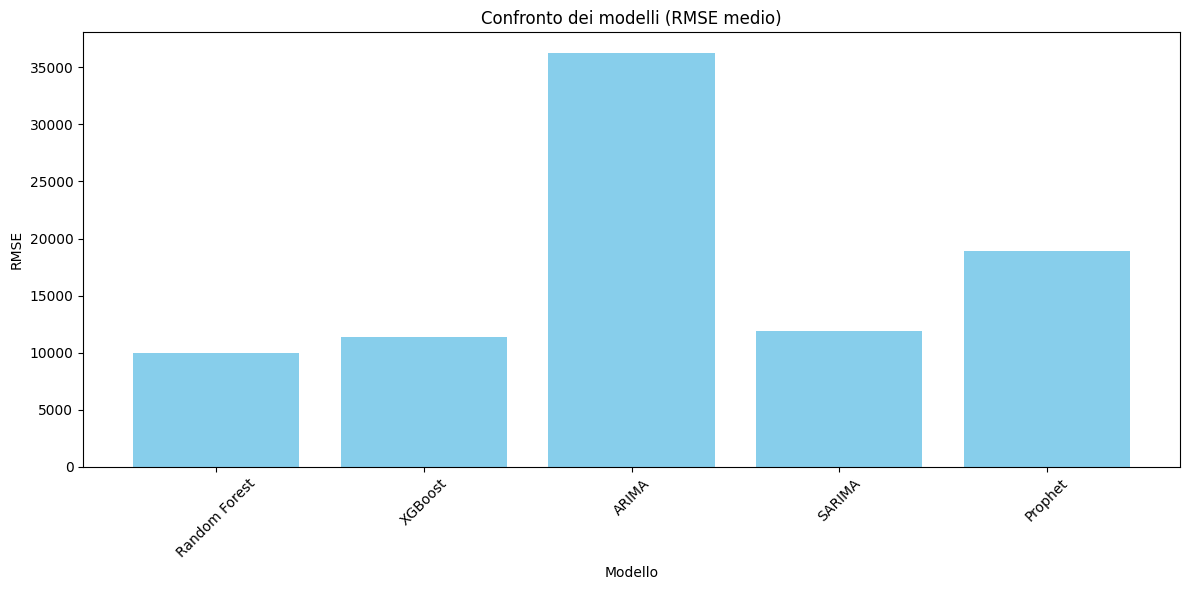

In [34]:
# Visualizziamo i risultati comparativi
plt.figure(figsize=(12, 6))
nomi_modelli = [risultato['nome'] for risultato in risultati_modelli]
rmse_values = [risultato['rmse_medio'] for risultato in risultati_modelli]

plt.bar(nomi_modelli, rmse_values, color='skyblue')
plt.title('Confronto dei modelli (RMSE medio)')
plt.xlabel('Modello')
plt.ylabel('RMSE')
plt.xticks(rotation=45)
plt.tight_layout()
plt.show()

In [35]:


test_size = 24 * 7  # 7 giorni di dati orari come test
X_train, X_test = X[:-test_size], X[-test_size:]
y_train, y_test = y[:-test_size], y[-test_size:]


rf_model = RandomForestRegressor(n_estimators=100, random_state=42)
rf_model.fit(X_train, y_train)
previsioni_finali = rf_model.predict(X_test)


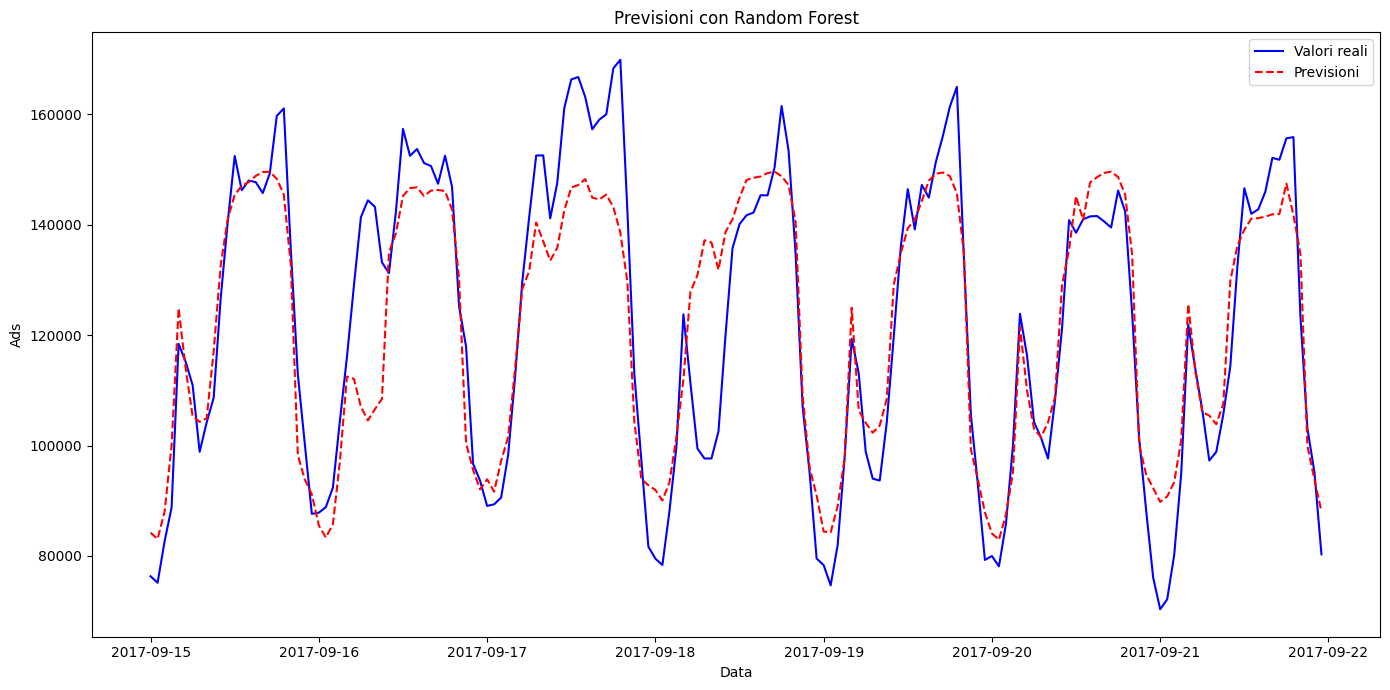


Metriche finali per Random Forest:
RMSE: 11614.92
MAE: 8396.04
R²: 0.8195


In [36]:
# Visualizziamo le previsioni finali
plt.figure(figsize=(14, 7))
plt.plot(y_test.index, y_test.values, label='Valori reali', color='blue')
plt.plot(y_test.index, previsioni_finali, label='Previsioni', color='red', linestyle='--')
plt.title(f'Previsioni con Random Forest')
plt.xlabel('Data')
plt.ylabel('Ads')
plt.legend()
plt.tight_layout()
plt.show()

# Calcoliamo le metriche finali
rmse_finale = np.sqrt(mean_squared_error(y_test, previsioni_finali))
mae_finale = mean_absolute_error(y_test, previsioni_finali)
r2_finale = r2_score(y_test, previsioni_finali)

print(f"\nMetriche finali per {miglior_modello['nome']}:")
print(f"RMSE: {rmse_finale:.2f}")
print(f"MAE: {mae_finale:.2f}")
print(f"R²: {r2_finale:.4f}")